<a href="https://colab.research.google.com/github/sebaszx/ProyectoFinalModulo2/blob/main/Proyecto_Ciencia_de_los_Datos_Modulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Descripción del proyecto

El presente estudio analiza patrones de las ecolocaciones ultrasónicas de murciélagos de la familia Mormoopidae.

- Este es un grupo de murciélagos de la región neotropical, que se alimenta principalmente de insectos, los cuales detectan mediante su sistema de ecolocación.

- Se obtuvieron registros de una colección de referencia del Dr. Bruce Miller, quien cuenta con una trayectoria de 25 años estudiando bioacústica de murciélagos.

- Todas las especies de la familia, excepto una, fueron estudiadas.

- Este proyecto analizó cerca de 30,000 registros de 11 especies. Estas 11 especies se agrupan en 2 géneros, 9 especies de *Pteronotus* y 2 especies de *Mormoops*.

<img src='https://raw.githubusercontent.com/levc17/Mormoopidae/main/PTEPER_Hefer Ávila_(CC BY 4.0).jpg'>

Ejemplo de la especie *Pteronotus personatus*. Fuente: Hefer Ávila (CC BY 4.0)

<img src='https://raw.githubusercontent.com/levc17/Mormoopidae/main/MORMEG_tereso30_(CC BY 4.0).jpg'>

Ejemplo de la especie *Mormoops megalophylla*. Fuente: tereso30 (CC BY 4.0)

<img src='https://raw.githubusercontent.com/levc17/Mormoopidae/main/Mormoopidae_FS.jpg'>

Grabaciones de audio de dos especies de mormópidos del género *Pteronotus*, en Guanacaste, Costa Rica. Fuente: LV

##Variables

Filename: código de archivo

st: indicador de posición dentro de archivo

Dur: duración de ecolocación (ms)

TBC: tiempo entre ecolocaciones (ms). Calculado cuando se obtienen valores de más de una ecolocación, en serie.

Fmax: Frecuencia máxima (kHz)

Fmin: Frecuencia mínima (kHz)

Fmean: Frecuencia promedio (kHz)

Tk: Tiempo entre el inicio de la ecolocación y su punto de inflexión (ms)

Fk: Frecuencia en punto de inflexión (kHz)

Qk: Significancia del punto de inflexión. Puede o no haber punto de inflexión en la ecolocación

Tc: Tiempo entre el inicio de la ecolocación y Fc (ms)

Fc: Frecuencia característica (kHz). Sección de la ecolocación con la menor pendiente absoluta.

Dc: Duración característica (ms)

S1: Pendiente inicial (OPS, octaves per second)

Sc: Pendiente característica (OPS, octaves per second)

Qual: Calidad de la ecolocación

Pmc: Proporción de Fmax relativa a Fc. Valor derivado.

Class: Especie de murciélago


<img src='https://raw.githubusercontent.com/levc17/Mormoopidae/main/Anabat_call parameters_Bruce Miller.JPG'>

Algunas de las variables utilizadas para describir los patrones acústicos de las ecolocaciones (Fmax, Fmin, Fc, Dur), a partir de archivos ZC (*zero-crossing*), usando Anabat software. Fuente: Bruce Miller.

In [ ]:
import tensorflow as tf
GPU=tf.config.experimental.list_physical_devices('GPU')
print("# de GPU detectados",len(GPU))
if len(GPU)>=1:
  tf.config.experimental.set_memory_growth(GPU[0],True)
  print("Tenemos GPU!")

# de GPU detectados 1
Tenemos GPU!


#Mount Drive
Se monta el drive, los datos para este proyecto no son de uso público. 

In [ ]:
#from google.colab import drive 
#drive.mount('/content/drive')
#%cd /content/drive/My\ Drive/Colab\ Notebooks/Ciencia\ de\ los\ dato/Modulo\ 2/Proyecto

In [ ]:
#TEMP: para usar con el Drive de Luis
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/Proyecto_final_ML

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Proyecto_final_ML


# Librerías
Sección del código donde la mayoría de librerías son importadas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay
from mlxtend.plotting import plot_decision_regions
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#Configuración

Al cambiar estos parámetros del notebook podemos cambiar su comportamiento

In [ ]:
isScaled=True
isBalanced=False
Epochs=300
DisplayGraphics=True
DropOutliers=False
verbose_=0

#Importación de datos 
Se lee el batch, cabe destacar que solo estamos leyendo 3000 filas por archivo. Esto con el fin de tener los datos un poco más balanceados

In [ ]:
df=pd.DataFrame(columns=["Filename","st","Dur","TBC","Fmax","Fmin","Fmean","Tk","Fk","Qk","Tc","Fc","Dc","S1","Sc","Qual","Pmc",'Class'])
df_2=pd.DataFrame(columns=["Filename","st","Dur","TBC","Fmax","Fmin","Fmean","Tk","Fk","Qk","Tc","Fc","Dc","S1","Sc","Qual","Pmc",'Class'])

Se cargan los archivos de las especies del género *Pteronotus* en un mismo DataFrame.

Se imprime el tamaño de cada archivo mientras se van añadiendo. 

In [ ]:
#Ptespp=["Ptespp1.txt","Ptespp2.txt","Ptespp3.txt","Ptespp4.txt","Ptespp5.txt","Ptespp6.txt","Ptespp8.txt","Ptespp10.txt"]
if not isBalanced:
  Ptespp=["Ptespp1.txt","Ptespp2.txt","Ptespp3.txt","Ptespp4.txt","Ptespp5.txt","Ptespp6.txt","Ptespp8.txt","Ptespp9.txt","Ptespp10.txt"]
else:
  Ptespp=["Ptespp1.txt","Ptespp2.txt","Ptespp3.txt","Ptespp4.txt","Ptespp5.txt","Ptespp6.txt","Ptespp8.txt","Ptespp10.txt"]
for count, value in enumerate(Ptespp):
  temp=pd.read_csv(value, sep='	|\t', engine='python',skiprows=1, nrows=5000, names=["Filename","st","Dur","TBC","Fmax","Fmin","Fmean","Tk","Fk","Qk","Tc","Fc","Dc","S1","Sc","Qual","Pmc"])
  temp['Class']=count
  
  print("Size of file #"+str(count), temp.shape )
  if value=="Ptespp2.txt": #Se tomó la decisión de hacerlo en esta etapa porque si usabamos el promedio con todos los datos estaríamos combinando datos entre clases 
    temp['TBC'].fillna((temp['TBC'].mean()), inplace=True)

  df=df.append(temp,ignore_index=True)

Size of file #0 (3761, 18)
Size of file #1 (2858, 18)
Size of file #2 (3962, 18)
Size of file #3 (2101, 18)
Size of file #4 (5000, 18)
Size of file #5 (5000, 18)
Size of file #6 (1482, 18)
Size of file #7 (132, 18)
Size of file #8 (5000, 18)


Luego Se cargan los archivos de las especies del género *Mormoops* en otro DataFrame.

Se imprime el tamaño de cada archivo mientras se van añadiendo.

Posteriormente, se concatenan ambos DataFrames para crear el conjunto de datos global, correspondiente a **11 especies de la familia Mormoopidae**.

In [ ]:
if not isBalanced:
  Morspp = ["Morspp1.txt","Morspp2.txt"]
for count, value in enumerate(Morspp):
  temp=pd.read_csv(value,sep=r';|\t', engine='python',
                   skiprows=4,
                   #skiprows=1,
                   nrows=5000,error_bad_lines=False,
                   names=["Filename","st","Dur","TBC","Fmax","Fmin","Fmean","Tk","Fk","Qk","Tc","Fc","Dc","S1","Sc","Qual","Pmc"])
 
  temp['Class']=len(Ptespp)+count
  
  print("Size of file #"+str(len(Ptespp)+count), temp.shape)

  df_2=df_2.append(temp,ignore_index=True)

Size of file #9 (301, 18)
Size of file #10 (313, 18)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Concatenación de ambos dataframes para generar el dataset de la familia

In [ ]:
df=df.append(df_2,ignore_index=True)

#Limpieza y Exploración de los datos

Se verifica que se cargaron bien los datos:

In [ ]:
df.head().T

,0,1,2,3,4
Filename,g4211839.21,g4211839.21,g4211839.21,g4211906.17,g4211906.17
st,0.00000,48.00000,85.00000,106.00000,120.00000
Dur,4.42000,2.71000,2.27000,1.26000,2.56000
TBC,0.00000,109.44000,133.56000,0.00000,99.07000
Fmax,69.87000,73.06000,71.43000,76.19000,80.40000
Fmin,62.75000,65.04000,64.78000,66.12000,63.75000
Fmean,65.08000,67.77000,67.05000,69.68000,75.09000
Tk,0.83000,0.22000,0.46000,0.55000,0.00000
Fk,67.23000,71.75000,68.97000,70.80000,80.40000
Qk,1.22000,1.45000,1.50000,1.42000,0.00000


In [ ]:
df.Class.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)

Se revisa el tamaño del dataset y se hace un conteo por clase (especie)

In [ ]:
df.shape

(29910, 18)

In [ ]:
df.groupby(['Class']).size()

Class
0     3761
1     2858
2     3962
3     2101
4     5000
5     5000
6     1482
7      132
8     5000
9      301
10     313
dtype: int64

Se verifica el tipo de columnas 

In [ ]:
df.dtypes

Filename     object
st           object
Dur         float64
TBC         float64
Fmax        float64
Fmin        float64
Fmean       float64
Tk          float64
Fk          float64
Qk          float64
Tc          float64
Fc          float64
Dc          float64
S1          float64
Sc          float64
Qual        float64
Pmc         float64
Class        object
dtype: object

Se eliminan las siguientes 3 columnas:

- FileName: código de archivo, no es relevante

- St: indicador de posición en archivo, no es relevante

- Qual: medición de la calidad de la grabación, pero no describe directamente los patrones acústicos de interés

In [ ]:
#df.drop(columns=['Filename','st','Qual','TBC'],inplace=True)
df.drop(columns=['Filename','st','Qual'],inplace=True)

Una columna adicional 'TBC' debe revisarse con mayor detenimiento.

- TBC: variable que presenta mucha varianza, puede ser útil para clasificar especies pero posiblemente está sujeta a muchos valores extremos. Podría introducir 'ruido' al conjunto de datos.

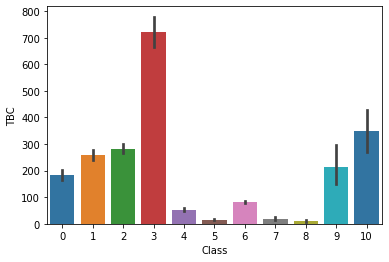

In [ ]:
sns.barplot(x = 'Class', y = 'TBC', data = df, palette = "tab10")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


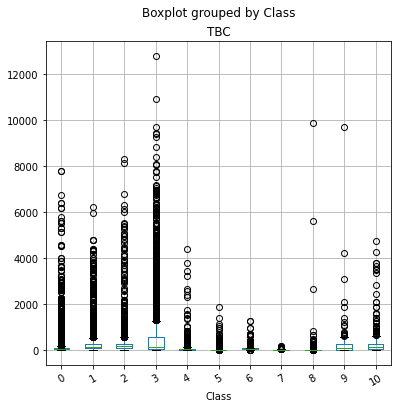

In [ ]:
df.boxplot('TBC', 'Class',rot = 30,figsize=(6,6))

In [ ]:
#df.hist(column='TBC', by='Class', figsize = (10, 10))

In [ ]:
def replace(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 3*std
    group[outliers] = mean
    return group

TBC = df.groupby('Class').TBC.transform(replace)

In [ ]:
print(TBC.shape)

df['TBC'] = TBC
print(df.shape)

(29910,)
(29910, 15)


In [ ]:
df.groupby(['Class']).size()

Class
0     3761
1     2858
2     3962
3     2101
4     5000
5     5000
6     1482
7      132
8     5000
9      301
10     313
dtype: int64

In [ ]:
#sns.barplot(x = 'Class', y = 'TBC', data = df, palette = "tab10")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


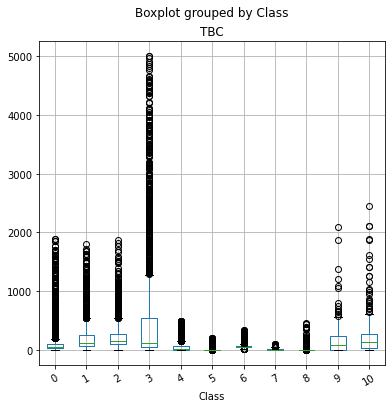

In [ ]:
df.boxplot('TBC', 'Class',rot = 30,figsize=(6,6))

Dado que 'TBC' aparentemente es útil para clasificar las especies y el procedimeinto de remoción de valores extremos ayudó a remover parte del 'ruido'. Se decidió mantener la variable 'TBC' en el dataset.

In [ ]:
df.columns

Index(['Dur', 'TBC', 'Fmax', 'Fmin', 'Fmean', 'Tk', 'Fk', 'Qk', 'Tc', 'Fc',
       'Dc', 'S1', 'Sc', 'Pmc', 'Class'],
      dtype='object')

Convertir datos en float:

In [ ]:
#display(df.iloc[29296])#Daba error sin el skip rows del morsp

In [ ]:
df = df.apply(pd.to_numeric)

Se verifica si existen NaNs:

In [ ]:
df.isna().sum()

Dur         0
TBC         0
Fmax        0
Fmin        0
Fmean       0
Tk          0
Fk          0
Qk          0
Tc          0
Fc          0
Dc          0
S1          0
Sc          0
Pmc      2101
Class       0
dtype: int64

Se observa que la columna 'PMC' no cuenta con algunos valores. Al asociar la cantidad con los tamaños de cada archivo, nos percatamos que corresponde a la especie 'Ptespp4', clase 3.

Dado que esta variable es derivada, puede calcularse a partir de las otras variables del dataset, entonces se procede a calcularla manualmente para completarlo.

In [ ]:
df['Pmc'] = np.where(df['Pmc'].isna(), ((df['Fmax']-df['Fc']*100)/df['Fc']), df['Pmc'])

Se verifica nuevamente si existen NaNs:

In [ ]:
df.isnull().sum(axis = 0)

Dur      0
TBC      0
Fmax     0
Fmin     0
Fmean    0
Tk       0
Fk       0
Qk       0
Tc       0
Fc       0
Dc       0
S1       0
Sc       0
Pmc      0
Class    0
dtype: int64

**Outliers**

Esta seción está ligada a la celda de configuración de la parte superior. Puede activarse para aplicar una función que elimina los outliers. Default = False.

In [ ]:
from scipy import stats
if DropOutliers:
  df=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #se necesita criterio experto para hablar de outliers
  print("Se eliminaron los outliers!")

In [ ]:
df.shape

(29910, 15)

Exploramos las estadisticas del dataset



In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Dur,29910.00000,3.42663,4.39579,0.06000,1.01000,2.17000,4.19000,33.02000
TBC,29910.00000,117.68573,318.90661,0.00000,1.27250,37.60000,115.02500,5007.70000
Fmax,29910.00000,64.38388,7.18070,48.63000,60.15000,63.49000,67.80000,86.49000
Fmin,29910.00000,58.74292,6.37022,43.01000,55.17000,58.82000,63.49000,82.47000
Fmean,29910.00000,61.60541,5.98890,47.62000,58.15000,60.61000,64.00000,82.97000
Tk,29910.00000,0.60323,1.35998,0.00000,0.00000,0.13000,0.54000,25.56000
Fk,29910.00000,62.68698,6.55251,48.19000,58.82000,60.84000,65.57000,86.02000
Qk,29910.00000,0.81538,1.20070,0.00000,0.00000,0.27000,1.20000,10.50000
Tc,29910.00000,2.70880,3.85177,0.06000,0.77000,1.67000,2.89000,30.92000
Fc,29910.00000,61.41909,6.06474,44.57000,56.74000,60.38000,64.52000,84.66000


###Visualización del conjunto de datos

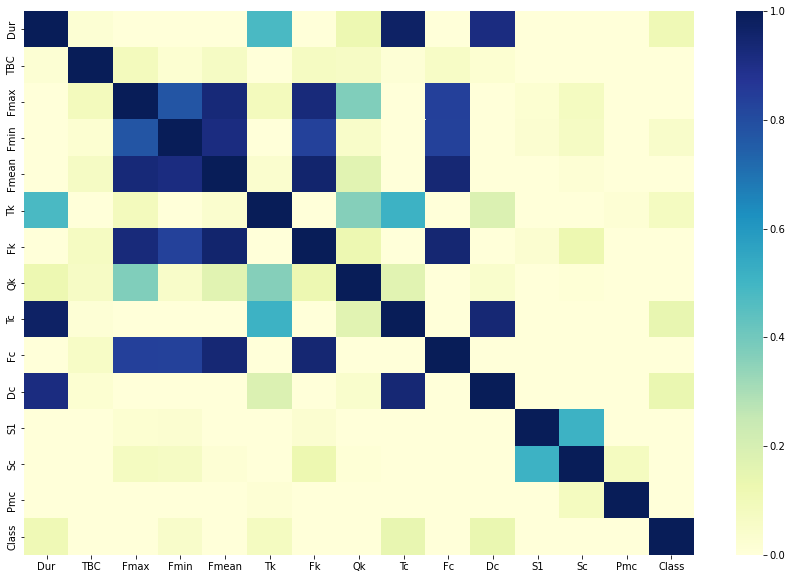

In [ ]:
import matplotlib.pyplot as plt

if DisplayGraphics:
  fig, ax = plt.subplots(figsize=(15,10)) 
  MatrixCorelation=df.corr()
  ax = sns.heatmap(MatrixCorelation,vmin=0, vmax=1, cmap="YlGnBu")
#print(MatrixCorelation)

In [ ]:
#sns.pairplot(df)

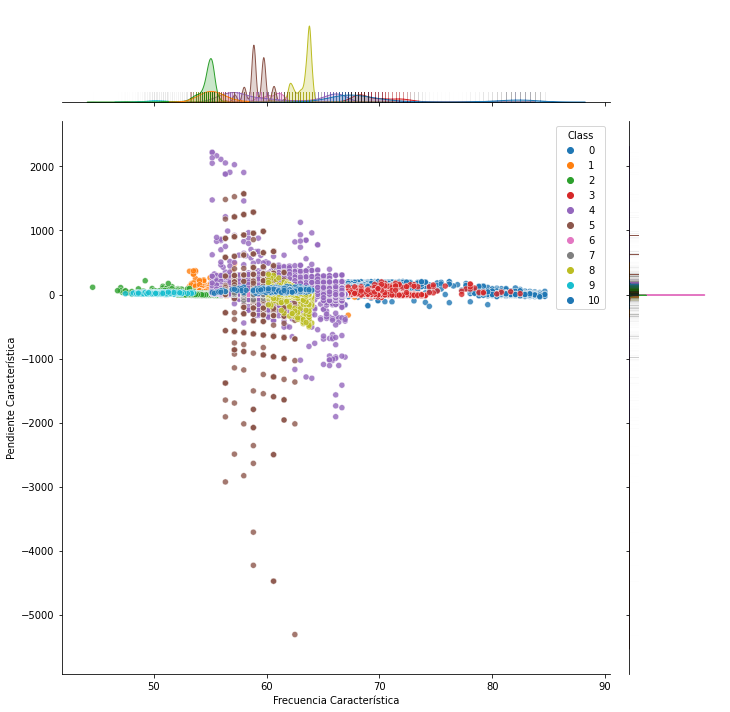

In [ ]:
if DisplayGraphics:
  wait = sns.jointplot(x = 'Fc', y = 'Sc', data = df, hue = 'Class',
                     height = 10, palette = 'tab10', alpha =0.8)
  wait.plot_marginals(sns.rugplot, height = 0.1, clip_on = False,
                    lw = 1, alpha = 0.005)
  wait.ax_joint.set_ylabel('Pendiente Característica')
  wait.ax_joint.set_xlabel('Frecuencia Característica')

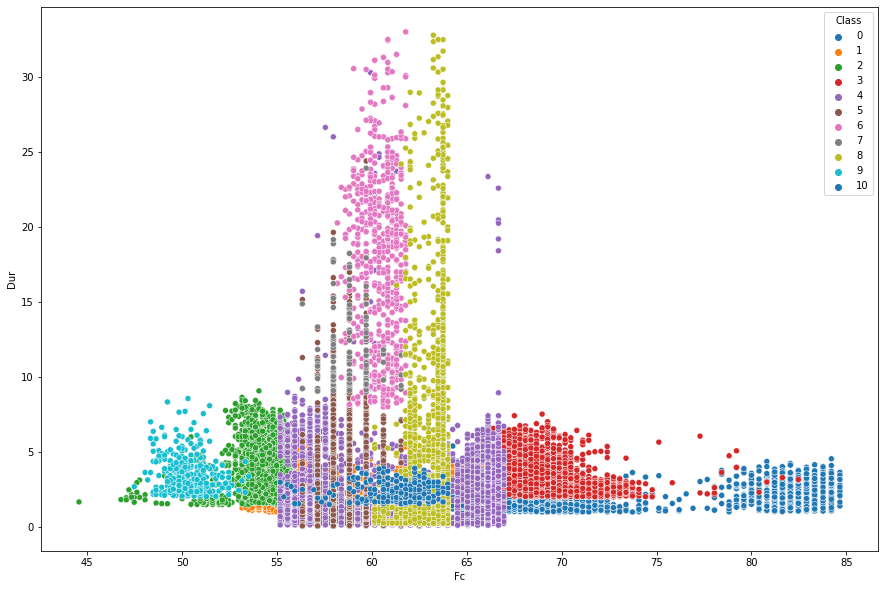

In [ ]:
if DisplayGraphics:
  fig, ax = plt.subplots(figsize=(15,10)) 
  ax = sns.scatterplot(data=df, x="Fc", y="Dur",hue='Class',palette = 'tab10')

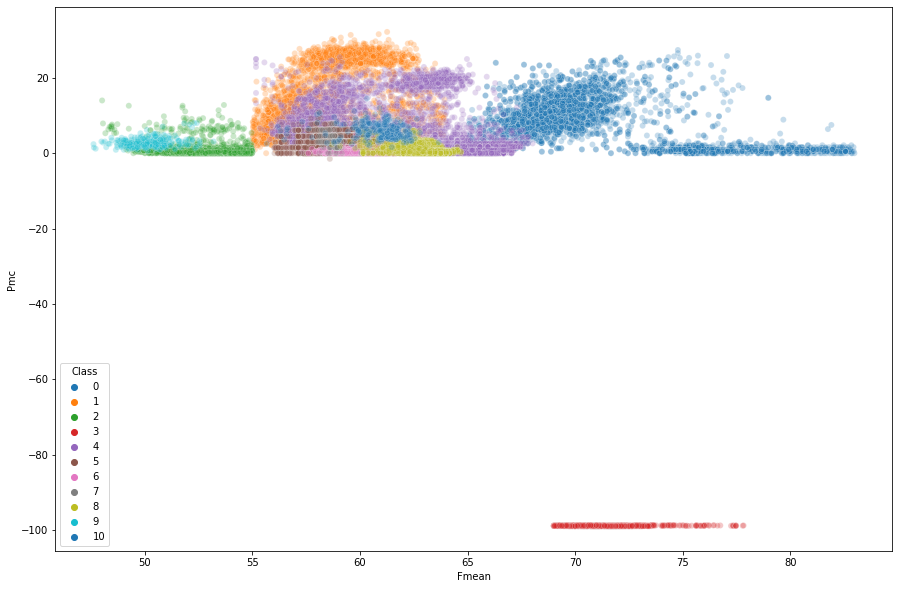

In [ ]:
if DisplayGraphics:
  fig, ax = plt.subplots(figsize=(15,10)) 
  ax = sns.scatterplot(data=df, x="Fmean", y="Pmc",hue='Class',palette = 'tab10',alpha=.25)

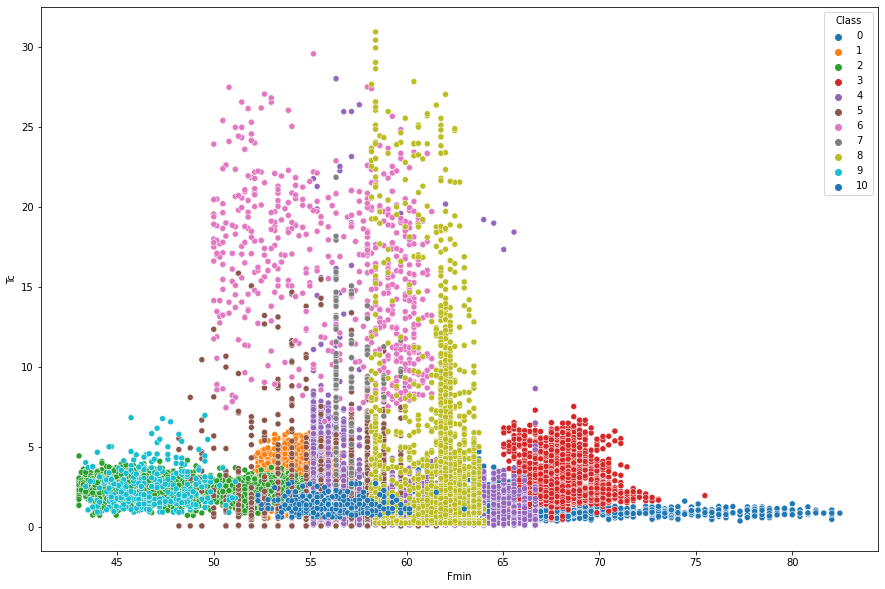

In [ ]:
if DisplayGraphics:
  fig, ax = plt.subplots(figsize=(15,10)) 
  ax = sns.scatterplot(data=df, x="Fmin", y="Tc",hue='Class',palette = 'tab10')

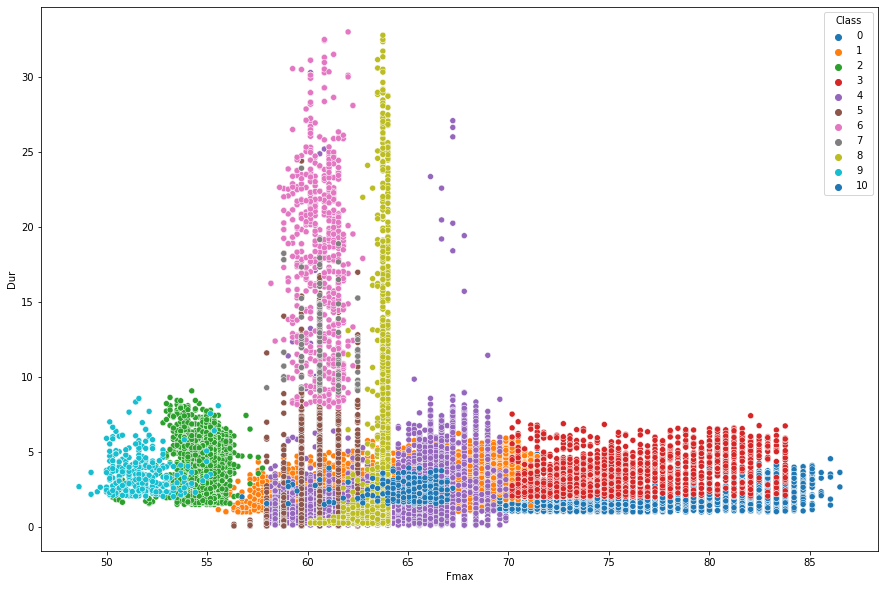

In [ ]:
if DisplayGraphics:
  fig, ax = plt.subplots(figsize=(15,10)) 
  ax = sns.scatterplot(data=df, x="Fmax", y="Dur",hue='Class',palette = 'tab10')

One Hot encode

In [ ]:
#se separan las y de los features
y=df['Class']
y_randomForest=y

y = pd.get_dummies(y, columns=['Class']) #One-hot encode


In [ ]:
y

,0,1,2,3,4,5,6,7,8,9,10
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
29905,0,0,0,0,0,0,0,0,0,0,1
29906,0,0,0,0,0,0,0,0,0,0,1
29907,0,0,0,0,0,0,0,0,0,0,1
29908,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.drop(['Class'], axis=1, inplace=True)
X=df
X_randomForest=X

In [ ]:
X

,Dur,TBC,Fmax,Fmin,Fmean,Tk,Fk,Qk,Tc,Fc,Dc,S1,Sc,Pmc
0,4.42000,0.00000,69.87000,62.75000,65.08000,0.83000,67.23000,1.22000,2.66000,64.26000,1.84000,159.13000,35.52000,8.70000
1,2.71000,109.44000,73.06000,65.04000,67.77000,0.22000,71.75000,1.45000,1.98000,66.39000,1.76000,120.33000,63.59000,10.00000
2,2.27000,133.56000,71.43000,64.78000,67.05000,0.46000,68.97000,1.50000,2.02000,65.57000,1.56000,112.00000,46.64000,8.90000
3,1.26000,0.00000,76.19000,66.12000,69.68000,0.55000,70.80000,1.42000,1.14000,66.95000,0.59000,254.41000,137.22000,13.80000
4,2.56000,99.07000,80.40000,63.75000,75.09000,0.00000,80.40000,0.00000,1.10000,79.21000,1.10000,71.60000,19.59000,1.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29905,2.70000,86.36000,59.04000,55.36000,56.30000,0.14000,57.97000,1.16000,1.55000,55.75000,1.42000,191.13000,39.79000,5.90000
29906,1.56000,65.38000,57.97000,55.94000,56.48000,0.00000,57.97000,0.00000,1.42000,55.94000,1.42000,74.14000,36.29000,3.60000
29907,1.60000,0.00000,62.75000,57.14000,59.93000,0.00000,62.75000,0.00000,1.19000,59.26000,1.19000,64.77000,69.53000,5.90000
29908,1.85000,124.60000,64.26000,57.55000,60.64000,0.13000,63.49000,0.47000,1.43000,59.48000,1.31000,136.05000,72.06000,8.00000


In [ ]:
#X = df.drop(['S1','Sc','Pmc'],axis=1)
#Features=SelectKBest(score_func=chi2,k='all').fit(X, y)

#scores=pd.DataFrame(Features.scores_)
#columns=pd.DataFrame(X.columns)

#feature_score=pd.concat([columns,scores],axis=1)
#feature_score.columns=['feature','score']
#feature_score.head()
#feature_score.sort_values(by=['score'],ascending=False,inplace=True)

#sns.barplot(data = feature_score, 
 #           x='score', 
  #          y='feature',
   #        palette='cividis'
    #      )



#Se escalan los datos

In [ ]:
if isScaled:
  scaler = MinMaxScaler()     #de la biblioteca Scikit-learn
  scaler.fit(X) 
  X = scaler.transform(X)
  print("Se escalaron los datos!")

Se escalaron los datos!


In [ ]:
X

array([[0.13228155, 0.        , 0.56101426, ..., 0.67350036, 0.70988428,
        0.82088415],
       [0.08040049, 0.02185434, 0.64527205, ..., 0.67015803, 0.71361187,
        0.83079268],
       [0.06705097, 0.02667093, 0.6022187 , ..., 0.66944046, 0.71136097,
        0.82240854],
       ...,
       [0.0467233 , 0.        , 0.37295298, ..., 0.66537194, 0.71440068,
        0.79954268],
       [0.05430825, 0.02488168, 0.41283677, ..., 0.67151219, 0.71473665,
        0.81554878],
       [0.06705097, 0.02515127, 0.40596936, ..., 0.66759012, 0.71353485,
        0.78506098]])

#Separación de datos

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,shuffle=True, random_state=10)

In [ ]:
X_train.shape

(23928, 14)

In [ ]:
X_test.shape

(5982, 14)

In [ ]:
y_train.shape

(23928, 11)

In [ ]:
y_test.shape

(5982, 11)

In [ ]:
y_test.head(10)

,0,1,2,3,4,5,6,7,8,9,10
26859,0,0,0,0,0,0,0,0,1,0,0
29170,0,0,0,0,0,0,0,0,1,0,0
16419,0,0,0,0,1,0,0,0,0,0,0
21665,0,0,0,0,0,1,0,0,0,0,0
27554,0,0,0,0,0,0,0,0,1,0,0
1415,1,0,0,0,0,0,0,0,0,0,0
11387,0,0,0,1,0,0,0,0,0,0,0
12328,0,0,0,1,0,0,0,0,0,0,0
12542,0,0,0,1,0,0,0,0,0,0,0
19418,0,0,0,0,0,1,0,0,0,0,0


#Modelo

##Random Forest

In [ ]:
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_randomForest, y_randomForest,test_size=0.20,shuffle=True, random_state=10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score

RF=RandomForestClassifier(n_estimators=200)
RF.fit(X_train_RF,y_train_RF)
predicted_RF=RF.predict(X_test_RF)

#Balanced 
score=balanced_accuracy_score(y_test_RF, predicted_RF)
print("balanced_accuracy_score",score)
#Accuracy
score=accuracy_score(y_test_RF, predicted_RF, normalize=True)
print("accuracy_score",score)

balanced_accuracy_score 0.9463994645671009
accuracy_score 0.9881310598462053


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils


# Building the model



##Modelo 1 MLP

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=14))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','accuracy'])
#model.compile(loss =tf.keras.losses.CategoricalCrossentropy(),
#              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#              metrics=['categorical_accuracy'])

model.summary()






Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1920      
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 activation_13 (Activation)  (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 activation_14 (Activation)  (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 11)               

##Modelo 2 MLP

In [ ]:

model_2=Sequential([Dense(units=5,activation='relu',input_dim=14),
                   #Dense(units=32,activation='relu'),
                   #Dense(units=64,activation='relu'),
                  
                   Dense(units=y_train.shape[1], activation='softmax')])
model_2.summary()
model_2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 5)                 75        
                                                                 
 dense_21 (Dense)            (None, 11)                66        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


#Entrenamiento

##Modelo 1

In [ ]:
with tf.device('/gpu:0'):
  history = model.fit(X_train, y_train, epochs=Epochs,validation_split=0.2, batch_size=100, verbose=verbose_)


dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])
300
[0.6619381308555603, 0.42092207074165344, 0.33698126673698425, 0.27759748697280884, 0.25188857316970825, 0.2444208264350891, 0.2336951643228531, 0.2256121039390564, 0.21368244290351868, 0.21007095277309418, 0.20144377648830414, 0.20781710743904114, 0.1893012821674347, 0.21572117507457733, 0.18418775498867035, 0.17997124791145325, 0.1736750453710556, 0.1684914082288742, 0.17519009113311768, 0.16303516924381256, 0.1578226089477539, 0.15428397059440613, 0.16111400723457336, 0.1649804562330246, 0.16718433797359467, 0.14977364242076874, 0.1509801298379898, 0.1447610855102539, 0.15902429819107056, 0.14879490435123444, 0.13798630237579346, 0.13329264521598816, 0.13724151253700256, 0.13459520041942596, 0.13264963030815125, 0.17337898910045624, 0.13072392344474792, 0.14092840254306793, 0.13405439257621765, 0.17050273716449738, 0.1457284688949585, 0.12582339346408844, 0.12897565960

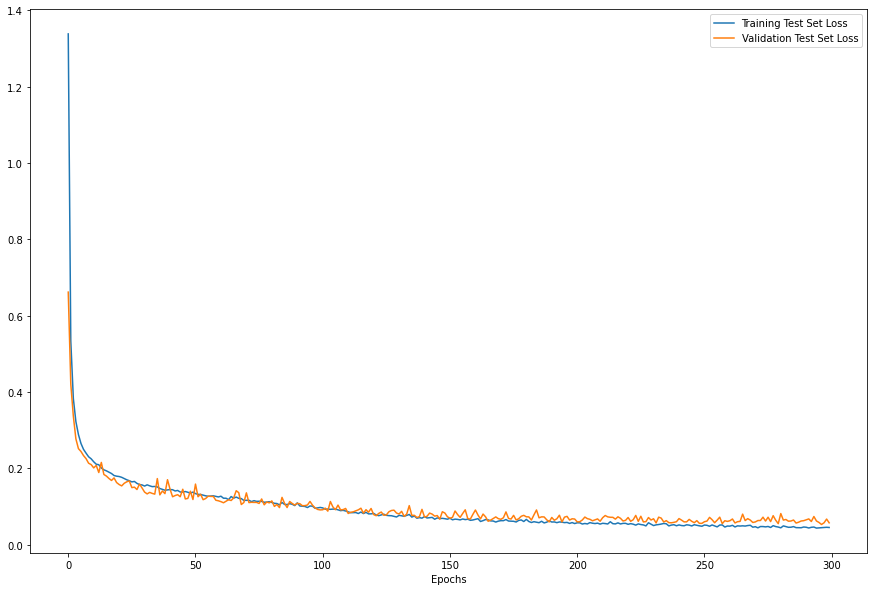

In [ ]:
print(history.history.keys())
print(len(history.history["loss"]))
print(history.history["val_loss"])
epoch=range(Epochs)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot( epoch,history.history["loss"], label = "Training Test Set Loss")
plt.plot( epoch,history.history["val_loss"], label = "Validation Test Set Loss")
#plt.plot( epoch,history.history["categorical_accuracy"], label = "Categorical Accuracy")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
model.save('Model1_weights.h5')

##Modelo 2

In [ ]:
with tf.device('/gpu:0'):
  history_2= model_2.fit(X_train, y_train, epochs=400,validation_split=0.2, batch_size=100, verbose=verbose_)

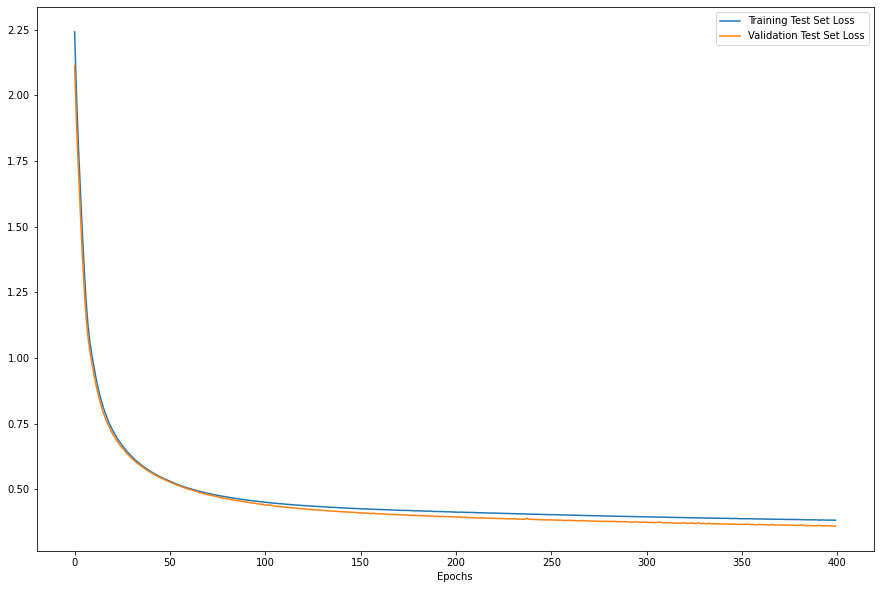

In [ ]:
epoch=range(400)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot( epoch,history_2.history["loss"], label = "Training Test Set Loss")
plt.plot( epoch,history_2.history["val_loss"], label = "Validation Test Set Loss")
#plt.plot( epoch,history_2.history["accuracy"], label = "Categorical Accuracy")
plt.xlabel('Epochs')
plt.legend()
plt.show()

#Evaluación 

##Modelo 1

In [ ]:
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

748/748 [==============================] - 2s 2ms/step - loss: 0.0413 - categorical_accuracy: 0.9838 - accuracy: 0.9838

 Training Accuracy: 0.9837846755981445
187/187 [==============================] - 0s 2ms/step - loss: 0.0538 - categorical_accuracy: 0.9803 - accuracy: 0.9803

 Testing Accuracy: 0.9802741408348083


In [ ]:
df_Xtest=pd.DataFrame(X_test)
#print(df_Xtest)
y_predict=model.predict(X_test,verbose=verbose_)
df_predict=pd.DataFrame(y_predict)
print(df_predict)
#print(y_predict.argmax(axis=1))
#print(y_predict)
#y_predict = (y_predict > 0.5) 
cm= confusion_matrix(y_test.values.argmax(axis=1), y_predict.argmax(axis=1))
#print(cm)

          0       1       2       3       4       5       6       7       8   \
0    0.00000 0.00000 0.00000 0.00000 0.45081 0.00000 0.00000 0.00000 0.54919   
1    0.00000 0.00000 0.00000 0.00000 0.00001 0.00000 0.00000 0.00000 0.99999   
2    0.00000 0.00035 0.00000 0.00000 0.99947 0.00018 0.00000 0.00000 0.00000   
3    0.00000 0.00002 0.00000 0.00000 0.00025 0.99973 0.00000 0.00001 0.00000   
4    0.00000 0.00000 0.00000 0.00000 0.01126 0.00000 0.00000 0.00000 0.98874   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5977 0.00000 0.00002 0.99998 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000   
5978 0.00000 0.00000 0.00000 0.00000 0.00023 0.99977 0.00000 0.00000 0.00000   
5979 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000   
5980 0.00000 0.99986 0.00000 0.00000 0.00001 0.00000 0.00000 0.00000 0.00000   
5981 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000   

          9       10  
0    0.00000 0.0

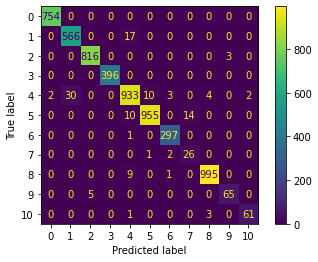

In [ ]:
#cm= confusion_matrix(y_test,y_predict)
cm_display= ConfusionMatrixDisplay(cm)
cm_display.plot()

##Modelo 2

In [ ]:
score = model_2.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model_2.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

748/748 [==============================] - 2s 2ms/step - loss: 0.3774 - accuracy: 0.8607

 Training Accuracy: 0.8607488870620728
187/187 [==============================] - 0s 2ms/step - loss: 0.3853 - accuracy: 0.8589

 Testing Accuracy: 0.858910083770752


In [ ]:
y_predict=model_2.predict(X_test,verbose=verbose_)
df_predict=pd.DataFrame(y_predict)
print(df_predict.head(10))
#print(y_predict.argmax(axis=1))
#print(y_predict)
#y_predict = (y_predict > 0.5) 
cm= confusion_matrix(y_test.values.argmax(axis=1), y_predict.argmax(axis=1))
#print(cm)

       0       1       2       3       4       5       6       7       8   \
0 0.00000 0.00049 0.00000 0.00000 0.19598 0.26819 0.00010 0.00160 0.53344   
1 0.00000 0.00029 0.00000 0.00000 0.02311 0.00002 0.00527 0.00019 0.97054   
2 0.00000 0.11198 0.00000 0.00000 0.64527 0.21100 0.00448 0.00020 0.01406   
3 0.00000 0.00790 0.00000 0.00000 0.16865 0.76625 0.00097 0.00364 0.05163   
4 0.00000 0.00041 0.00000 0.00000 0.24576 0.02260 0.00003 0.00018 0.73069   
5 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000   
6 0.00811 0.00000 0.00000 0.99189 0.00000 0.00000 0.00000 0.00000 0.00000   
7 0.00497 0.00000 0.00000 0.99503 0.00000 0.00000 0.00000 0.00000 0.00000   
8 0.00487 0.00000 0.00000 0.99513 0.00000 0.00000 0.00000 0.00000 0.00000   
9 0.00000 0.00040 0.00000 0.00000 0.03832 0.90360 0.00066 0.00509 0.05187   

       9       10  
0 0.00000 0.00020  
1 0.00000 0.00057  
2 0.00000 0.01301  
3 0.00000 0.00096  
4 0.00000 0.00032  
5 0.00000 0.00000  
6 0.00000 0.

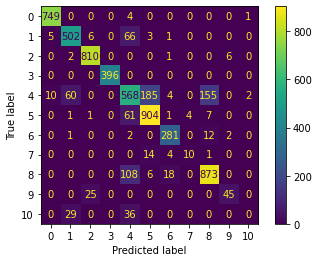

In [ ]:
cm_display= ConfusionMatrixDisplay(cm)
cm_display.plot()

#Prueba Manual

Se escogió un dato aleatorio del dataset Ptespp5.txt que el modelo no haya visto. Esto con el fin de poder verificar de una forma manual que en efecto nuestro modelo es capaz de clasificar murciélagos basado en la frecuencia de sus sonidos.

In [ ]:
PruebaPtespp5=np.array([[2.20	, 59.01, 66.67	,64.00	,65.45	,0.18,66.12	,0.09	,1.59,66.67	,1.40	,-193.08,-8.53,0.0]])
PruebaPtespp5=scaler.transform(PruebaPtespp5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
#model.summary()
test_predict=model.predict(PruebaPtespp5)
#print(test_predict)
test_predict.argmax(axis=1)

array([4])